# Monomial matrices and transformations on them

## Libraries

In [25]:
import sys; sys.path.append("../modules")
from collections.abc import Iterator

import random
import numpy as np
import sympy; sympy.init_printing()
from tqdm.notebook import tqdm

from Permutation import * # as pm
from Grid import *

# ----- Debugger -----
# from IPython.core.debugger import Pdb; Pdb().set_trace()

## Monomial Matrix Class

In [42]:
class MonomialMatrix(dict):
    '''A monomial matrix in a form of a pair of a diagonal matrix and a permutation matrix.'''
    def __init__(self, diag, perm):
        if not ((type(diag) is list) and (type(perm) is Permutation)): raise(TypeError)
        if not len(diag) == perm.size: raise(ValueError("len(diag) != perm.size"))
        
        self['diagonal'] = diag
        self['permutation'] = perm
        self.size = len(diag)
        self.matrix = sympy.diag(*self['diagonal'])*sympy.Matrix(self['permutation'].matrix())
        
    def represented_PM(self) -> Permutation:
        d, p = self['diagonal'], self['permutation']
        size, pinv = sum([abs(v) for v in d]), p.inverse()
    
        I, A = sympy.eye(size), sympy.zeros(0,size)
        for k in range(len(d)):
            x = abs(d[k])
            sign = 1 if d[k]==x else -1
            prev = [abs(d[pinv.act(j)]) for j in range(p.act(k))]
            abov = [abs(d[i]) for i in range(k)]
            sp, sa = sum(prev), sum(abov)
        
            for i in range(x):
                start = sp if sign == 1 else sp+x-1
                A = A.row_insert(sa+i, I.row(start+sign*i))
        #---
        img :list = [np.where(row > 0)[0][0] for row in np.array(A)]
        return Permutation(img)
    
    def grid_generator(self) -> Iterator[str]:
        hline = "+---" * self.size + "+"
        vline = "|   " * self.size + "|"
        for row in np.array(self.matrix):
            if (idx := np.where(row != 0)[0][0]):
                val = row[idx]
                val_str = f"{abs(val)}"
                if val < 0: val_str = "\033[31m" + val_str + "\033[0m"
                yield hline + "\n" + vline[: 4*idx+2] + val_str + vline[4*(idx+1)-1 :]
            else: yield hline + "\n" + vline
        else: yield hline

    def show_in_grid(self) -> None:
        for line in self.grid_generator(): print(line)
#---    
MM = MonomialMatrix

### scratch

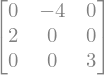

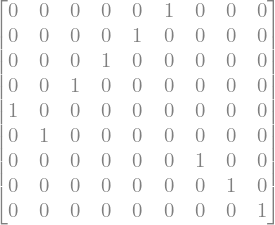

+---+---+---+
|   | 4 |   |
+---+---+---+
|   |   |   |
+---+---+---+
|   |   | 3 |
+---+---+---+


In [44]:
mm = MM([-4,2,3], Perm([1,0,2])) #; print(type(mm), mm['diagonal'], mm['permutation'].act(0))
aprm = mm.represented_PM()
pmtx = sympy.Matrix(aprm.matrix())

display(mm.matrix, pmtx)
#for row in mm.grid_generator(): print(row)
mm.show_in_grid()

## Correctness checking function

In [29]:
def correctness_checking(code, restriction='') -> tuple[list[dict, dict],str]:
    a,b,c,r = code[0], code[1], code[2], code[3]
    d = 2*a+b+c
    memo = ''

    #-- Set the starting MM --#
    if a >= r:
        case = "a>=r"
        s_diag, s_perm_img = [-a,b,c,-a,-(a-r),c,b,-(a-r),-2*r], [8,2,1,5,3,7,6,0,4]
    elif r<=a+c:
        case = "a<r<=a+c"
        s_diag, s_perm_img = [-a,b,r-a,a+c-r,-a,a+c-r,b,-2*a,r-a], [8,1,3,0,4,7,5,2,6]
    elif r<=a+b+c:
        case = "a+c<r<=a+b+c"
        s_diag, s_perm_img = [-a,r-a-c,a+b+c-r,c,-a,a+b+c-r,-2*a,c,r-a-c], [8,3,0,2,4,6,1,7,5]
    elif r<d:
        case = "a+b+c<r<d"
        s_diag, s_perm_img = [-a,b,c,-a,-(d-r),-(d-r),-(a+r-d),c,b,-(a+r-d)], [9,4,3,6,1,0,5,8,7,2]
    else: 
        case = 'ERROR'

    #-- Get a transformed MM --#
    A = a%r
    X, Xi = b, c
    Xseq = [(X,Xi)]
    while Xi > r:
        X = X%(Xi-r)
        Xi = (Xi-r)-X
        Xseq.append((X,Xi))
    case += " --> Xseq={} --> ".format(Xseq)
    #---
    if r == Xi:
        case += "Xi=r"
        if restriction in case:
            diag, perm_img = [2*r,2*A,2*X], [1,0,2]
            memo = f"(a,r)+X={(a, r)}+{X}={np.gcd(a,r)}+{X}"
        else: case = 'SKIP'
    else: #r > Xi:
        case += "Xi<r"
        Z = X%(r-Xi)
        Zi = (r-Xi)-Z
        if restriction in case:
            # diag, perm_img = [Zi,Z,Xi,Zi,Z,Xi,2*a], [3,2,1,6,5,4,0]
            diag, perm_img = [Zi,Z,Xi,Zi,Z,Xi,2*A], [3,2,1,6,5,4,0]
        else: case = 'SKIP'
        
    #-- Return MMs --#
    sdata, rdata = None, None
    if not 'SKIP' in case: 
        smm = MM(s_diag, Permutation(s_perm_img))
        sdata = {'mm': smm, '#orbits': len(cycle_decomp(smm.represented_PM())), 'memo': ''}
        #---
        rmm = MM(diag, Permutation(perm_img))
        rdata = {'mm': rmm, '#orbits': len(cycle_decomp(rmm.represented_PM())), 'memo': memo}
    return [sdata, rdata], case    

### Experiments

In [39]:
N = 10
restriction = '' #"Xi<r" #"r<d" #"" #

case = 'SKIP'
while 'SKIP' in case: #
    code = [0,0,0,0]
    while code[0]*code[3] == 0:
        code = [random.randint(0,N) for i in range(4)]
        d = 2*code[0]+code[1]+code[2]
        code[3] = code[3]%(2*code[0]+code[1]+code[2]) if d > 0 else 0
    data = correctness_checking(code, restriction)
    case = data[1]
        
#-- Display --
print(f"{code=}, {case=}")
nums :list = [int(data[0][i]['#orbits']/2) for i in [0,1]]
err_str = "\033[31m!! nums are different !!\033[0m"
print(f"{nums=}" + (err_str if not nums[0] == nums[1] else '') + f", memo: {data[0][1]['memo']}")

gg1, gg2 = data[0][0]['mm'].grid_generator(), data[0][1]['mm'].grid_generator()
flag = True
while flag:
    left = next(gg1)
    right = (next(gg2)).replace("\n",'')
    print(next(gg1) + '    ' + next(gg2))

code=[2, 8, 2, 3], case='a<r<=a+c --> Xseq=[(8, 2)] --> Xi<r'
nums=[2, 2], memo: 
+---+---+---+---+---+---+---+---+---+
|   | 8 |   |   |   |   |   |   |   |    +---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
| 1 |   |   |   |   |   |   |   |   |    +---+---+---+---+---+---+---+
|   |   |   |   |   |   | 1 |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   | 1 |   |    +---+---+---+---+---+---+---+
|   |   |   |   | 2 |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   | 4 |   |   |   |   |   |   |    +---+---+---+---+---+---+---+


StopIteration: 

In [38]:
mstr = "\n" + "ABC"
print(mstr)
print(mstr.replace("\n",""))


ABC
ABC


In [6]:
R, N, skipped, ones = 200, 20, 0, 0
rstn = '' #'r<d' #'a+b+c' #"Xi=r" #"r<=a+c"

for count in tqdm(range(R)):
    case = 'SKIP'
    while 'SKIP' in case:
        code = [0,0,0,0]
        while code[0]*code[3] == 0:
            code = [random.randint(0,N) for i in range(4)]
            d = 2*code[0]+code[1]+code[2]
            code[3] = code[3]%d if d>0 else 0
        data = correctness_checking(code, rstn)
        case = data[1]
        if 'SKIP' in case: skipped += 1
            
    nums = [int(data[0][i]['#orbits']/2) for i in [0,1]]
    if nums[0] == 1: ones += 1
    if not nums[0] == nums[1]:
        print(f"nums are different!! {nums=} / {code=}, {case=}")
        for d in data[0]:
            d['mm'].show_in_grid() #; display(mm.matrix)
            print(d['memo'])
    
print(f"{ones=},  {skipped=}")

  0%|          | 0/200 [00:00<?, ?it/s]

ones=106,  skipped=0


### scratch

In [ ]:
a,b,c = random.randint(1,10),random.randint(1,10), random.randint(1,10)
r = c + random.randint(1,5)
# a,b,c,r = 9,4,8,3

b1=b%(c-r)
c1=(c-r)-b1

Z = b1%(r-c)
Zi = (r-c)-Z

mm1 = MM([Zi,Z,c,Zi,Z,c,2*(a%r)], Perm([3,2,1,6,5,4,0]))
mm2 = MM([r,b,c,r,b,c,2*(a%r)], Perm([3,2,1,6,5,4,0]))
mm3 = MM([c1,b1,c,c1,b1,c,2*(a%r)], Perm([3,2,1,6,5,4,0]))
mm4 = MM([Zi,Z,c,Zi,Z,c,2*(a%r)], Perm([3,2,1,6,5,4,0]))
mms = [mm1, mm2, mm3, mm4]

print([len(cycle_decomp(mm.represented_PM())) for mm in mms], 2*np.gcd(a,r))
[mm.show_in_grid() for mm in mms]

In [ ]:
a,b,c = random.randint(1,10),random.randint(1,10), random.randint(1,10)
r = c + random.randint(1,5)

Z = b%(r-c)
Zi = (r-c)-Z

mm1 = MM([Zi,Z,c,Zi,Z,c,2*(a%r)+r], Perm([6,5,4,3,2,1,0]))
mm2 = MM([Zi,Z,c,a%r], Perm([1,2,3,0]))
mm3 = MM([Zi,Z,c,a%r], Perm([2,3,0,1]))

nums = []
for mm in [mm1, mm2, mm3]: 
    mm.show_in_grid()
    nums.append(len(cycle_decomp(mm.represented_PM())))
print(nums)

In [ ]:
a, r = random.randint(1,10), random.randint(1,10) #1, 1 #
A = a%r

mm1 = MM([-A, -(2*r-A),-2*r,A],Perm([2,3,0,1]))
mm2 = MM([2*r-A,-A,A],Perm([2,1,0]))
mm3 = MM([2*r,-A,A],Perm([2,0,1]))
mms = [mm1, mm2, mm3]

[mm.show_in_grid() for mm in mms]

print([len(cycle_decomp(mm.represented_PM())) for mm in mms], 2*np.gcd(A,r))

### Nando

In [ ]:
def correctness_checking(code, restriction=''):
    a,b,c,r = code[0], code[1], code[2], code[3]
    sdata, rdata, case, memo = None, None, None, ''

#-- Transforming MMs --
    if a >= r:
        case = "a>=r"
        s_diag, s_perm_img = [-a,b,c,-a,-(a-r),c,b,-(a-r),-2*r], [8,2,1,5,3,7,6,0,4]
        #---
        A = a%r
        X, Xi = b, c
        Xseq = [X]
        while Xi > r:
            X = X%(Xi-r)
            Xi = (Xi-r)-X
            Xseq.append(X)
        case += ", ...Xseq={}...".format(Xseq)
        if r == Xi:
            case += ", Xi=r"
            if restriction in case:
                diag, perm_img = [2*r,2*A,2*X], [1,0,2]
                memo = "(A,r)+X=({},{})+{}={}+{}".format(A, r, X, np.gcd(A, r),X)
            else: case = None
        else: #r > Xi:
            case += ", Xi<r"
            Z = X%(r-Xi)
            Zi = (r-Xi)-Z
            if restriction in case:
                diag, perm_img = [Zi,Z,Xi,Zi,Z,Xi,2*A], [3,2,1,6,5,4,0]
                # diag, perm_img = [Zi,Z,Xi,Zi,Z,Xi,(2*A+r)%(2*r)], [6,5,4,3,2,1,0]
            else: case = None
    elif r <= a+c:
        case = "a<r<=a+c"
        s_diag, s_perm_img = [-a,b,r-a,a+c-r,-a,a+c-r,b,-2*a,r-a], [8,1,3,0,4,7,5,2,6]
        #---
        B = b%a
        Bi = a-B
        if False: #r == a+c:
            case += ", r=a+c"
            if restriction in case:
                diag, perm_img = [r, Bi, B, B, Bi, r], [2,1,0,5,4,3]
                memo = "(a,r-B)=({},{})={}".format(a, r-B, np.gcd(a,r-B))
            else: case = None
        elif r <= a+c:
            case += ", r<=a+c"
            X, Xi = b, c
            Xseq = [X]
            while Xi > r:
                X = X%(Xi-r)
                Xi = (Xi-r)-X
                Xseq.append(X)
            case += ", ...Xseq={}...".format(Xseq)
            if r == Xi:
                case += ", Xi=r"
                R = r%(2*a)
                Ri = 2*a-R
                if restriction in case:
                    diag, perm_img = [-R,-Ri,-Ri,-R,2*X], [2,3,0,1,4]
                    # diag, perm_img = [r,-2*a,-2*a,r,2*X], [1,3,0,2,4]
                    # memo = "(R,Ri)=({},{})={}".format(R,Ri,np.gcd(R,Ri))
                else: case = None
            else: #r > Xi
                case += ", Xi<r"
                Z = X%(r-Xi)
                Zi = (r-Xi)-Z
                if restriction in case:
                    # diag, perm_img = [Zi,Z,Xi,-2*a,-2*a,Xi,Z,Zi], [3,2,1,7,0,6,5,4]
                  c  diag, perm_img = [Zi,Z,Xi,Zi,Z,Xi,2*a], [3,2,1,6,5,4,0]
                else: case = None
        else: case = None
    elif a+c < r < a+b+c:
        case = "a+c<r<a+b+c"
        ###=== CONSTRUCTING NOW! ===###        
        case = None
    else: case = None
    #----    
    if case is not None: 
        starting_mm = MM(s_diag, pm.Permutation(s_perm_img))
        sdata = {'mm': starting_mm, '#orbits': len(pm.cycle_decomp(starting_mm.associate_PM())), 'memo': ''}
        #---
        resulting_mm = MM(diag, pm.Permutation(perm_img))
        rdata = {'mm': resulting_mm, '#orbits': len(pm.cycle_decomp(resulting_mm.associate_PM())), 'memo': memo}
#----    
    return [sdata, rdata], case

In [ ]:
def correctness_checking(code, restriction=''):
#-- Starting MM --
    a,b,c,r = code[0], code[1], code[2], code[3]
    starting_mm = MM([-a,b,c,-a,-(a-r),c,b,-(a-r),-2*r], pm.Permutation([8,2,1,5,3,7,6,0,4]))
    snum  = len(pm.cycle_decomp(starting_mm.associate_PM()))
    sdata = {'mm': starting_mm, '#orbits': snum, 'memo': ''}

#-- Resulting MM --
    flag = True
    resulting_mm, rnum, memo = None, None, ''
    if a-r>=0:
        case = "a>=r"
        if r-c == 0:
            case += ", r=c"
            if restriction in case:
                resulting_mm = MM([-r,-a,-(a-r),r,a-r,-2*r,2*b], pm.Permutation([4,2,0,3,5,1,6]))
                rnum = len(pm.cycle_decomp(resulting_mm.associate_PM())) + 2*b
                memo = ", b={}".format(b)
            else: case = "(x)"
        elif r-c > 0:
            case += ", r>c"
            X, Y = b%(r-c), (a-r)%(2*r)
            Xi, Yi = (r-c)-X, (2*r)-Y
            if restriction in case:
                resulting_mm = MM([Xi,X,c,Xi,X,c,2*Y], pm.Permutation([3,2,1,6,5,4,0]))
                rnum = len(pm.cycle_decomp(resulting_mm.associate_PM()))
            else: case = "(x)"
            # if Xi == Y:
            #     case += ", Xi=Y"
            #     resulting_mm = MM([X,c,Xi,X,c,Xi], pm.Permutation([2,1,0,5,4,3]))
            #     rnum = 2*np.gcd(X+c, r-X) #len(pm.cycle_decomp(resulting_mm.associate_PM()))
            #     memo = ", (X+c, r-X)=({},{})={}".format(X+c, r-X, np.gcd(X+c, r-X))
            # elif Xi > Y:
            #     case += ", Xi>Y"
            #     Z = Xi-Y
            #     # resulting_mm = MM([-Z,-X,-c,-Z,Y,-X,-c,-Y,-Yi], pm.Permutation([5,7,8,2,0,3,4,6,1]))
            #     # resulting_mm = MM([-Z,X,c,Z,Y,-X,-c,-Y,-r], pm.Permutation([7,2,1,4,0,5,6,8,3]))
            #     # resulting_mm = MM([Z,X,c,Z,Y,X,c,Y], pm.Permutation([4,2,1,7,0,6,5,3]))
            #     resulting_mm = MM([Xi,X,c,Xi,X,c,2*Y], pm.Permutation([3,2,1,6,5,4,0]))
            #     rnum = len(pm.cycle_decomp(resulting_mm.associate_PM()))
            # else:
            #     case += ", Xi<Y"
            #     # resulting_mm = MM([-Xi,-X,-c,-Xi,-X,-c,Y,-Y,-Yi], pm.Permutation([6,7,8,3,4,5,0,1,2]))
            #     resulting_mm = MM([Xi,X,c,Xi,X,c,2*Y], pm.Permutation([3,2,1,6,5,4,0]))
            #     rnum = len(pm.cycle_decomp(resulting_mm.associate_PM()))
        else: # r-c < 0
            case += ", r<c"
            X, Y = b%(c-r), (a-r)%(2*r)
            Xi, Yi = (c-r)-X, (2*r)-Y
            # if r-Yi == 0:
            #     case += ", r=Yi"
            #     if restriction in case:
            #         resulting_mm = MM([Xi,X,r,r,X,Xi], pm.Permutation([2,1,0,5,4,3]))
            #         rnum = len(pm.cycle_decomp(resulting_mm.associate_PM()))
            #     else: case = "(x)"
            # else:
                # case += ", r!=Yi"
            if r-Xi == 0:
                case += ", r=Xi"
                if restriction in case:
                    resulting_mm = MM([-Y,-Yi,-2*r,Y,2*X], pm.Permutation([2,3,0,1,4]))
                    rnum = len(pm.cycle_decomp(resulting_mm.associate_PM()))
                    memo = ", (Y,r)+X=({},{})+{}={}+{}".format(Y, r, X, np.gcd(Y, r),X)
                else: case = "(x)"
            if r-Xi > 0:
                case += ", r>Xi"
                Z = X%abs(r-Xi)
                Zi = abs(r-Xi)-Z
                if restriction in case:
                    # resulting_mm = MM([2*Y,Xi,X,r,r,X,Xi], pm.Permutation([6,2,1,0,5,4,3]))
                    # resulting_mm = MM([Xi,X,-Y,-Yi,-r,X,Xi,-r,Y], pm.Permutation([2,1,7,8,3,5,4,0,6]))
                    # resulting_mm = MM([Xi,X,-Y,-(Yi-r),r,X,Xi,-r,Y], pm.Permutation([2,1,6,8,7,4,3,0,5]))
                    # resulting_mm = MM([Xi,X,-r,r,X,Xi,-r,2*Y], pm.Permutation([2,1,7,6,4,3,0,5]))
                    resulting_mm = MM([Zi,Z,Xi,Zi,Z,Xi,2*Y], pm.Permutation([3,2,1,6,5,4,0]))
                    rnum = len(pm.cycle_decomp(resulting_mm.associate_PM()))
                else: case = "(x)"
            else: case = "(x)"
    else: case = "(x)"
    rdata = {'mm': resulting_mm, '#orbits': rnum, 'memo': memo}
#----    
    return [sdata, rdata], case